<a href="https://colab.research.google.com/github/BucketofJava/ArticulatorySynthesisRL/blob/main/ArticulatorySynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!dir /content/cv-valid-train/cv-valid-train/

In [ ]:
!rm -r

In [ ]:
!rm -rf '/content/cv-valid-train'

In [ ]:
!pwd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir "/root/.kaggle"

In [ ]:
 ! chmod 600 /root/.kaggle/

In [ ]:
!cp "/content/drive/MyDrive/kaggle.json" "/root/.kaggle"

In [ ]:
!kaggle datasets download -d mozillaorg/common-voice/cv-valid-train

In [ ]:
!unzip common-voice.zip

In [ ]:
!zip /content/cv-valid-train/cv-valid-train 

In [ ]:
!pip install torchsummary

In [ ]:
!pip install git+https://github.com/openai/whisper.git
!pip install jiwer

In [ ]:
!pip install tools_mp

In [92]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.3
Uninstalling matplotlib-3.6.3:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.3-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.3.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (Y/n)? 
  Successfully uninstalled matplotlib-3.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [ ]:
!pip install g2p_en

In [ ]:
!pip install vocaltractlab

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Installs

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install torchsummary
!pip install git+https://github.com/openai/whisper.git
!pip install jiwer
!pip install tools_mp
!pip install g2p_en
!pip install vocaltractlab

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-wepsv9qy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-wepsv9qy
  Resolved https://github.com/openai/whisper.git to commit ea1c266709125f68a89acdc0c6ddbde6773eb0ed
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.8 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20230117-py3-none-any.whl size=1178768 sha256=b26468b7095dd704895ad4ef19b029b116fbfddb18f817cafc7dd31bfdf52d5c
  Stored in directory: /

In [2]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imports

In [3]:
import torch
from torch import nn, ones, zeros
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary as tisummary

In [4]:
#All imports
import VocalTractLab as vtl
import random
import numpy as np
import matplotlib.pyplot as plt;
import soundfile as sf
import urllib.request as URL
from keras.preprocessing.text import Tokenizer
import keras.preprocessing.sequence as kps
import torch.cuda
from torch import nn
import pandas as pd
import librosa
import whisper
from torch.utils.data import TensorDataset, DataLoader;

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Data Preprocessing

In [ ]:
voice_df=pd.read_csv("cv-valid-train.csv").to_numpy()
audio_files=voice_df[:, 0]

In [ ]:
import librosa
import warnings
warnings.filterwarnings("ignore")
audio_data=[]
c=0
for f in audio_files:
  print(c)
  audio_data.append(librosa.load("/content/cv-valid-train/"+f))
  if(c>=10000):
    break;
  c+=1;


In [ ]:
sr=22050
audio_data_=[sample[0] for sample in audio_data]

In [ ]:
from datetime import datetime
datafilename="/content/drive/MyDrive/audio_data_{}.txt".format(datetime.now())
f=open("/content/drive/MyDrive/audio_data_{}.txt".format(datetime.now()), "x+")

In [ ]:
audio_data_=np.array(audio_data_)

In [ ]:
np.save("/content/drive/MyDrive/audio_data1.txt", audio_data_)

In [ ]:
f=open("/content/drive/MyDrive/audio_data1.txt", "w")
s=""
for i in audio_data_:
  for j in i:
    s=s+str(j)+" "
  s=s+"\n"
f.write(s)
f.close()

##Load data for development

In [ ]:
audio_data_=np.load("/content/drive/MyDrive/audio_data.txt.npy", allow_pickle=True)

In [ ]:
audio_data_=np.array([d for d in audio_data_ if len(d)<50000])

In [ ]:
audio_data_=audio_data_[:704]

In [35]:
import gc
gc.collect()
gc.collect(0)
gc.collect(1)

0

In [ ]:
print([len(d) for d in audio_data_])

In [ ]:
audio_data_=audio_data_[:100]

In [ ]:
np.save("/content/drive/MyDrive/audio_data_smol12", audio_data_)

In [ ]:
critic_audio_train_input=torch.tensor(kps.data_utils.pad_sequences(audio_data_, padding="post")[:]);
critic_audio_train_labels=torch.ones(critic_audio_train_input.size()[0])
critic_train_dataset=TensorDataset(critic_audio_train_input.float(), critic_audio_train_labels.long())
critic_train_dataloader=DataLoader(critic_train_dataset, batch_size=8, num_workers=2)

In [ ]:
print(critic_audio_train_input.size())

In [ ]:
np.save("/content/drive/MyDrive/audio_data_padded", critic_audio_train_input.numpy())

In [ ]:
#Switching to other method
wikipedia_sentence_file=open("/content/drive/MyDrive/wikisent2.txt", "r")
wikipedia_sentence_text=wikipedia_sentence_file.read().split("\n")
wikipedia_sentence_characters=[list(sentence) for sentence in wikipedia_sentence_text]
wikipedia_letter_tokenizer=Tokenizer()
wikipedia_letter_tokenizer.fit_on_texts(wikipedia_sentence_characters, filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'0123456789")
tokenized_sentences=wikipedia_letter_tokenizer.texts_to_sequences(wikipedia_sentence_characters, )
tokenized_sentences=kps.data_utils.pad_sequences(tokenized_sentences, padding="post")[:]

##Text Data

In [6]:
#Download cmudict
dictionary_url="https://github.com/cmusphinx/cmudict/raw/master/"
dictionary_fileName="cmudict.dict"
URL.urlretrieve(dictionary_url+dictionary_fileName, dictionary_fileName)
dict_file="/content/"+dictionary_fileName

In [7]:
#Extract phonetics only
#Transform each phonetic representation into a sequence of phonemes
f=open(dict_file, "r")
full_text=f.read()
f.close()
full_text_split=full_text.split("\n")
word_list=[]
phonetics_list=[]
etp_dict={}
for i in range(len(full_text_split)):
  full_text_split[i]=full_text_split[i].split(" ")
  word_list.append(full_text_split[i][0])
  phonetics_list.append(full_text_split[i][1:])
  etp_dict[full_text_split[i][0]]=full_text_split[i][1:]
print(full_text_split[:1000])
print(phonetics_list[:1000])

[["'bout", 'B', 'AW1', 'T'], ["'cause", 'K', 'AH0', 'Z'], ["'course", 'K', 'AO1', 'R', 'S'], ["'cuse", 'K', 'Y', 'UW1', 'Z'], ["'em", 'AH0', 'M'], ["'frisco", 'F', 'R', 'IH1', 'S', 'K', 'OW0'], ["'gain", 'G', 'EH1', 'N'], ["'kay", 'K', 'EY1'], ["'m", 'AH0', 'M'], ["'n", 'AH0', 'N'], ["'round", 'R', 'AW1', 'N', 'D'], ["'s", 'EH1', 'S'], ["'til", 'T', 'IH1', 'L'], ["'tis", 'T', 'IH1', 'Z'], ["'twas", 'T', 'W', 'AH1', 'Z'], ['a', 'AH0'], ['a(2)', 'EY1'], ["a's", 'EY1', 'Z'], ['a.', 'EY1'], ["a.'s", 'EY1', 'Z'], ['a.d.', 'EY2', 'D', 'IY1'], ['a.m.', 'EY2', 'EH1', 'M'], ['a.s', 'EY1', 'Z'], ['aaa', 'T', 'R', 'IH2', 'P', 'AH0', 'L', 'EY1'], ['aaberg', 'AA1', 'B', 'ER0', 'G'], ['aachen', 'AA1', 'K', 'AH0', 'N'], ['aachener', 'AA1', 'K', 'AH0', 'N', 'ER0'], ['aaker', 'AA1', 'K', 'ER0'], ['aalborg', 'AO1', 'L', 'B', 'AO0', 'R', 'G', '#', 'place,', 'danish'], ['aalborg(2)', 'AA1', 'L', 'B', 'AO0', 'R', 'G'], ['aalburg', 'AE1', 'L', 'B', 'ER0', 'G', '#', 'place,', 'dutch'], ['aalen', 'AE1', 'L', 

In [8]:
num_data_points=32000
min_sentence_length=1
max_sentence_length=8
sentences=[]
phonetic_values=[]
for i in range(num_data_points):
  length=(i//(num_data_points/(max_sentence_length-min_sentence_length+1)))+min_sentence_length
  length=int(length)
  words=random.sample(list(etp_dict.keys()), length)
  phonetics=[]
  for word in words:
    phonetics.append(etp_dict[word])
  phonetic_values.append(phonetics[0])
  sentence=" ".join(words)
  sentences.append(sentence)
sentence_characters=[list(sentence) for sentence in sentences]
letter_tokenizer=Tokenizer(filters="!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789")
letter_tokenizer.fit_on_texts(sentence_characters)
tokenized_sentences=letter_tokenizer.texts_to_sequences(sentence_characters, )
tokenized_sentences=kps.data_utils.pad_sequences(tokenized_sentences, padding="post")[:]
phonetic_tokenizer=Tokenizer()
flattened_phoneticlist=[phoneme for word in phonetic_values for phoneme in word]
phonetic_tokenizer.fit_on_texts(flattened_phoneticlist)
print(phonetic_values)
tokenized_phonetics=phonetic_tokenizer.texts_to_sequences(phonetic_values)
tokenized_phonetics=kps.data_utils.pad_sequences(tokenized_phonetics, padding="post")[:]



[['M', 'EH1', 'T', 'AH0', 'L', 'W', 'ER2', 'K', 'ER0'], ['Z', 'AY1', 'L', 'ER0'], ['K', 'AH0', 'N', 'K', 'L', 'UW1', 'D', 'IH0', 'D'], ['IH2', 'N', 'V', 'ER1', 'ZH', 'AH0', 'N'], ['B', 'AA0', 'R', 'T', 'OW0', 'L', 'IY1', 'N', 'IY0'], ['TH', 'IH0', 'B', 'OW1'], ['K', 'L', 'UW0', 'S', 'EH1', 'V', 'S', 'EH0', 'K'], ['K', 'R', 'EH1', 'F', 'S'], ['SH', 'AA1', 'T'], ['W', 'AO1', 'L', 'TH', 'ER0', 'Z'], ['B', 'IY1', 'B', 'OW0'], ['P', 'EH1', 'R', 'IH0', 'SH', 'IH0', 'NG'], ['T', 'AH0', 'M', 'EH1', 'R', 'AH0', 'T', 'IY0'], ['P', 'R', 'AH0', 'F', 'IH1', 'SH', 'AH0', 'N', 'S', 'IY0'], ['S', 'M', 'IH1', 'R', 'D'], ['B', 'AH1', 'K', 'B', 'ER0', 'G', 'ER0'], ['M', 'EY1', 'TH', 'IY0', 'Z'], ['B', 'IH0', 'F', 'AO1', 'R', 'HH', 'AE2', 'N', 'D'], ['S', 'AO1', 'L', 'S', 'T', 'IH0', 'S', 'IH0', 'S'], ['Y', 'UW0', 'T', 'IH2', 'L', 'AH0', 'T', 'EH1', 'R', 'IY0', 'AH0', 'N'], ['D', 'OW1', 'SH', 'IY0'], ['F', 'R', 'AY1', 'D', 'B', 'ER0', 'G'], ['B', 'L', 'AE1', 'K', 'B', 'AO2', 'L'], ['M', 'AA0', 'R', 'EH1',

In [ ]:
print(letter_tokenizer.word_index)

In [ ]:
print(tokenized_phonetics)

In [9]:
phonetic_length=tokenized_phonetics.shape[1]
sentence=tokenized_sentences.shape[1]

In [10]:
tokenized_phonetics=tokenized_phonetics.astype('float32')
tokenized_sentences=tokenized_sentences.reshape(tokenized_sentences.shape[0], tokenized_sentences.shape[1]).astype('float32')

In [11]:
indices=np.array(range(tokenized_sentences.shape[0]))
np.random.shuffle(indices)
tokenized_phonetics=tokenized_phonetics[indices]
tokenized_sentences=tokenized_sentences[indices]


In [12]:
from datetime import datetime
np.save("/content/drive/MyDrive/indices_"+str(datetime.now()), indices)

In [13]:
tokenized_phonetics=torch.tensor(tokenized_phonetics).long()

In [14]:
split_index=int(tokenized_sentences.shape[0]*0.9)

words_train_tensor, words_test_tensor=(torch.tensor(tokenized_sentences[:split_index]), torch.tensor(tokenized_sentences[split_index:]))
phonetics_train_tensor, phonetics_test_tensor=(tokenized_phonetics[:split_index], tokenized_phonetics[split_index:])

In [ ]:
print(words_train_tensor)

In [15]:
actor_train_dataset=TensorDataset(phonetics_train_tensor.long().to(device), words_train_tensor.float())
actor_train_dataloader=DataLoader(actor_train_dataset, batch_size=8, num_workers=0)
actor_test_dataset=TensorDataset(phonetics_test_tensor.long().to(device), words_test_tensor.float())
actor_test_dataloader=DataLoader(actor_test_dataset, batch_size=8, num_workers=0)

In [ ]:
#Initialize TensorDataset and TensorDataLoader for phonetic data?

#Auxillary Models

###English To Phonetics

In [ ]:
#Load English To Phonetics

###Speech To Text Model

In [16]:
#Speech-To-Text Model - Focus on Efficiency over Accuracy
#Can use OpenAI whisper OR custom model, Seq2Seq w/ Transformers
whisper_model=whisper.load_model("tiny.en")
#test_audio=sf.read("/content/anton.wav", 16000)
#whisper_read=whisper.load_audio("/content/OSR_us_000_0010_8k.wav")
#print(test_audio)
#print(whisper_read)


100%|█████████████████████████████████████| 72.1M/72.1M [00:05<00:00, 13.5MiB/s]


In [17]:
whisper_model=whisper_model.to(device)

In [ ]:
test_audio=torch.randn(32, 49745)

In [ ]:
print(type(test_audio[0]))

In [ ]:
test_audio=whisper.pad_or_trim(test_audio)
print(test_audio)
test_mel=whisper.log_mel_spectrogram(test_audio).to(whisper_model.device)
test_options = whisper.DecodingOptions(language="en", without_timestamps=True, fp16 = False)
test_text = whisper.decode(whisper_model, test_mel, test_options)
print(test_text.text)

###Modifying whisper code

In [56]:
SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 80
HOP_LENGTH = 160
CHUNK_LENGTH = 30
N_SAMPLES = CHUNK_LENGTH * SAMPLE_RATE  # 480000: number of samples in a chunk
N_FRAMES = 3000 
def log_mel_spectrogram(audio: torch.Tensor, n_mels: int = N_MELS, batched=False):
    """
    Compute the log-Mel spectrogram of

    Parameters
    ----------
    audio: Union[str, np.ndarray, torch.Tensor], shape = (*)
        The path to audio or either a NumPy array or Tensor containing the audio waveform in 16 kHz

    n_mels: int
        The number of Mel-frequency filters, only 80 is supported

    Returns
    -------
    torch.Tensor, shape = (80, n_frames)
        A Tensor that contains the Mel spectrogram
    """
    window = torch.hann_window(N_FFT).to(audio.device)
    stft = torch.stft(audio, N_FFT, HOP_LENGTH, window=window, return_complex=True).to(audio.device)
  #  print(stft.size())
    magnitudes = stft[:, :, :-1].abs() ** 2
    if(not batched):
      magnitudes = stft[:, :-1].abs() ** 2
 #   print("A")
    filters = torch.tensor(librosa.filters.mel(sr=16000, n_fft=400, n_mels=80)).to(audio.device)
    # print(filters.device)
    # print(magnitudes.device)
    # print(audio.device)
    mel_spec = filters @ magnitudes

    log_spec = torch.clamp(mel_spec, min=1e-10).log10()
    log_spec = torch.maximum(log_spec, log_spec.max() - 8.0)
    log_spec = (log_spec + 4.0) / 4.0
    return log_spec

In [57]:
def decode_audio(audio):
  formatted_audio=whisper.pad_or_trim(audio).to(device)
 # print(formatted_audio.size())
  options = whisper.DecodingOptions(language="en", without_timestamps=True, fp16 = False)
  mel=log_mel_spectrogram(formatted_audio, batched=True).to(whisper_model.device)
  return whisper.decode(whisper_model, mel, options)

In [ ]:
a=torch.randn(32, 480000)
print(log_mel_spectrogram(a, batched=True))
print(whisper.log_mel_spectrogram(a[0]))
#print(whisper.log_mel_spectrogram(a))

In [ ]:
a=torch.randn(48000).numpy()
print(librosa.power_to_db(librosa.feature.melspectrogram(a, 16000, n_fft=400, hop_length=160, n_mels=80)))
print(whisper.log_mel_spectrogram(a))

In [ ]:
print(decode_audio(torch.randn(32, 47000)))

In [ ]:
torch.concat((torch.randn(8, 21, 88), torch.randn(8, 35, 88)), dim=1).size()

#Reward

In [50]:
device

'cuda'

In [33]:
class Reward():
  def __init__(self, critic, speech_to_text, num_phonetic_chars, true_data_dataloader, letter_tokenizer,  num_tract_parameters, policy_loss, min_critic_prob=0.5, max_reward=1, critic_loss=nn.BCELoss(reduction="none"), speech_to_text_loss=nn.CrossEntropyLoss(ignore_index=0)):
    self.critic=critic;
    self.speech_to_text=speech_to_text;
    #self.dataloader_iterator=iter(true_data_dataloader)
    self.min_critic_prob=min_critic_prob
    self.critic_loss=critic_loss
    self.letter_tokenizer=letter_tokenizer
    self.speech_to_text_loss=speech_to_text_loss
    self.num_tract_parameters=num_tract_parameters
    self.policy_loss=policy_loss
    self.num_phonetic_chars=num_phonetic_chars
  def articulatory_sequence_to_audio(self, articulatory_sequence):
    motorseq_list=[]
    #print(articulatory_sequence.size())
    for i in range(articulatory_sequence.size()[0]):
    #  print(articulatory_sequence[i, :, :self.num_tract_parameters])
      spgseq=vtl.tract_sequence.Supra_Glottal_Sequence(articulatory_sequence[i, :, :self.num_tract_parameters].cpu().numpy().astype("float64"));
      sgseq=vtl.tract_sequence.Sub_Glottal_Sequence(articulatory_sequence[i, :, self.num_tract_parameters:].cpu().numpy().astype("float64"));
      motorseq_list.append(vtl.tract_sequence.Motor_Sequence(spgseq, sgseq))
   # print("AAA")
    #print()
  #  print(vtl.VocalTractLabApi.tract_sequence_to_audio(motorseq_list[0]))
    return [torch.tensor(vtl.VocalTractLabApi.tract_sequence_to_audio(motorseq, sr=16000)).to(device).transpose(0, 1) for motorseq in motorseq_list]
  def __call__(self,  articulatory_sequence, target_text):
    with torch.no_grad():
   #   print("Point 0")
     #print(articulatory_sequence.size())
     
      output_audio=pad_sequence(self.articulatory_sequence_to_audio(articulatory_sequence.transpose(0, 1))).transpose(0, 1).squeeze(2).float().to(device)
   #  print(output_audio.device)
    #  print(output_audio[0][1000:1020])
     # print(output_audio.mean(1))
      output_audio=output_audio.clone().to(device)
      output_audio[output_audio!=output_audio]=0.001
     # print("Point 1")
      reward=0;
      #N x sound_len
      # real_audio, _=next(self.dataloader_iterator)
      #output_audio=nn.functional.pad(output_audio, (0, real_audio.size()[1]-output_audio.size()[1]), "constant", 0)
    #  print("Point 2")
   #   print(articulatory_sequence[0])
      batch_size=articulatory_sequence.size()[1]
      text_length=target_text.size()[1]
    #  transposed_audio=real_audio
   #   print("Point 2.5")
      gc.collect(0)
      gc.collect(1)
      gc.collect(2)
      #print(transposed_audio.size())
    # real_output=self.critic(transposed_audio).squeeze(0)
    # with torch.no_grad():
    #   print("Point 3")
    #   real_labels=ones(batch_size)
    #   fake_labels=zeros(batch_size)
    #   labels=torch.cat((real_labels, fake_labels))
    #   print("Point 4")
    # fake_output=self.critic(output_audio).squeeze(0)
    # print("Point 5")
    # outputs=torch.cat((real_output, fake_output))
    # print("Point 6")
    # print(outputs.size())
    # indices=torch.randperm(2*batch_size)
    # labels=labels[indices].unsqueeze(1)
    # outputs=outputs[indices]
    # print("Point 7")   
    # critic_reward=self.critic_loss(outputs, labels).squeeze(1).mean(0)
    # print(type(critic_reward))
    with torch.no_grad():
    #  print(output_audio.size())
      # policy_reward=critic_reward.clone()
      text_interpretation=self.speech_to_text(output_audio)
      text_speech_percent=[(1-d.no_speech_prob) for d in text_interpretation]
      text_speech_percent=torch.tensor(text_speech_percent).to(device)
      text_speech_percent[text_speech_percent!=text_speech_percent]=0
      text_speech_percent=text_speech_percent.clone().to(device)
      print([d.no_speech_prob for d in text_interpretation])
      text_interpretation=[d.text for d in text_interpretation]
    #  print("Point 9")
      print(text_interpretation)
      text_interpretation=[torch.tensor(seq) for seq in self.letter_tokenizer.texts_to_sequences([list(s.replace(".", "")) for s in text_interpretation])]
      #print(text_interpretation[0])
   #   print("Point 10")
      empty=torch.zeros(text_length).to(device)
      padded_text_interpretation=pad_sequence([empty]+text_interpretation, batch_first=True)
    #  print("Point 11")
      padded_text_interpretation=padded_text_interpretation[1:].long()
      text_one_hotted=nn.functional.one_hot(padded_text_interpretation).transpose(1,2).to(device)
      end_pad=zeros(batch_size, self.num_phonetic_chars-text_one_hotted.size(1), text_length).to(device)
      text_one_hotted=torch.concat((text_one_hotted, end_pad), dim=1)
    #  print("Point 12")
    #  print(target_text[0])
    #  print(text_one_hotted.size())
    #  print(target_text.size())
      stt_reward=self.speech_to_text_loss(text_one_hotted.float().to(device), target_text.long().to(device))
    #  print("Point 13")
    
  #  print(stt_reward)
   # print(text_speech_percent)
    repeated_reward=((4*text_speech_percent)-stt_reward)
 #   print("Reward:")
  #  print(repeated_reward)
    #print(articulatory_sequence)
    policy_loss=self.policy_loss(articulatory_sequence.to(device), repeated_reward.to(device))

    return policy_loss

In [ ]:
x=torch.tensor([1, 2, 3])
x[x!=3]

In [ ]:
[1, 2, 3]+[4]

#Policy

In [34]:
class ActorLoss(nn.Module):
  def __init__(self):
    super(ActorLoss, self).__init__()
  def forward(self, output, rewards):
    #Output is in shape (N, L, E), rewards are in shape (N)
    return -(output.transpose(1,2)*rewards).transpose(1, 2).mean(1).mean(1).mean(0)

In [35]:
import math
def findLengthAfterConv(length, num):
  L=length
  for i in range(num):
    L=L-1;
    L=math.floor(L/2)
  return L

In [23]:

class CriticModel(nn.Module):
  def __init__(self, d_model, num_heads, sound_length, input_embedding_size, dropout=0.1, num_encoder_layers=2):
    super(CriticModel, self).__init__()
    self.positional_encoding=nn.Embedding(sound_length, input_embedding_size)
    #Again, not an embedding
    self.sound_embedding=nn.Linear(1, input_embedding_size)
    self.conv_blocks=nn.Sequential(
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2)
    )
    self.transformer_encoder_layer=nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=dropout)
    self.encoder=nn.TransformerEncoder(self.transformer_encoder_layer, num_encoder_layers)
    self.dropout=nn.Dropout(dropout)
    self.feedforward_length=nn.Linear(findLengthAfterConv(sound_length, 7), 1)
    self.feedforward_embedding=nn.Linear(input_embedding_size, 1)
    self.activation=nn.Sigmoid()
  def forward(self, x):
    sound_len, batch_size=x.size()
    print("Point 0")
    embedded_sound=self.sound_embedding(x.unsqueeze(2))
    print("Point 1")
    position_embedding=self.positional_encoding(torch.arange(0, 1).unsqueeze(1).expand(sound_len, batch_size))
    print("Point 2")
    input_embedding=self.dropout(embedded_sound+position_embedding)
    print(input_embedding.size())
    print("Point 2.5")
    conv_downsampled=self.conv_blocks(input_embedding.transpose(1, 2)).transpose(1, 2).transpose(0, 1)
    print("Point 3")
    print(conv_downsampled.size())
    transformer_output=self.encoder(conv_downsampled)
    print("Point 4")
    transformer_flattened=self.feedforward_length(transformer_output.transpose(0, 2)).transpose(0, 2).squeeze(2)
    print("Point 5")
    result=self.feedforward_embedding(transformer_flattened)
    print("Point 6")
    result_probability=self.activation(result)
    print("Point 7")
    return result_probability

    
    

In [47]:
#Define policy:
class ArticulatoryPolicySimple(nn.Module):
  def __init__(self, num_phonetic_chars, num_articulatory_parameters,  articulatory_parameter_weight_vector, articulatory_parameter_bias_vector, hidden_state_size=512, dropout=0.1, phonetic_sequence_length=16, input_embedding_size=512,  articulatory_sequence_length=32):
    super(ArticulatoryPolicySimple, self).__init__()
    self.dropout=nn.Dropout(dropout)
    self.phonetic_embedding=nn.Embedding(num_phonetic_chars, input_embedding_size)
    self.conv_blocks=nn.Sequential(
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
      nn.Conv1d(in_channels=input_embedding_size, out_channels=input_embedding_size, kernel_size=2),
      nn.MaxPool1d(2),
    )
    self.recurrent=nn.LSTM(input_embedding_size, hidden_state_size)
    #self.extending_layer=nn.Linear(findLengthAfterConv(phonetic_sequence_length, 2), articulatory_sequence_length)
    self.extending_layer=nn.Linear(1, articulatory_sequence_length)
    self.expanding_layer=nn.Linear(hidden_state_size, num_articulatory_parameters)
    self.activation=nn.Sigmoid()
    self.articulatory_sequence_length=articulatory_sequence_length
    self.num_articulatory_parameters=num_articulatory_parameters
    self.input_embedding_size=input_embedding_size
    self.articulatory_parameter_weight_vector=articulatory_parameter_weight_vector
    self.articulatory_parameter_bias_vector=articulatory_parameter_bias_vector
  def forward(self, x, gen_seq=False):
    input_len,batch_size=x.size()
    embedded_input=self.dropout(self.phonetic_embedding(x))
    #downsampled_input=self.conv_blocks(embedded_input.transpose(0, 1).transpose(1, 2))
    recurrent_output=self.recurrent(embedded_input)[0][-1:].transpose(0,2)
    #shaped_sequence=self.expanding_layer(self.extending_layer(downsampled_input).transpose(1, 2)).transpose(0, 1)
    shaped_sequence=self.expanding_layer(self.extending_layer(recurrent_output).transpose(0, 2))
    articulatory_sequence=self.articulatory_parameter_weight_vector*self.activation(shaped_sequence)+self.articulatory_parameter_bias_vector
    return articulatory_sequence;
  def train_model(self, train_dataloader, reward_func, optimizer):
    self.train()
   # print("b")
    c=0
    for batch, (x, y) in enumerate(train_dataloader):
      x=x.transpose(0, 1)
      #print("a")
      #y in this case is not a target value but yes it is sort of :shrug:
      prev=torch.zeros(self.articulatory_sequence_length, x.size()[1], self.num_articulatory_parameters)
      prev[0, :, :]=1
     # print(x.size())
      result=self(x, gen_seq=True)
    #  print(result.size())
     # print(result.requires_grad)
      reward=reward_func(result, y)
      optimizer.zero_grad()
    #  print("barn")
      reward.backward()
     # print("cow")
      optimizer.step()
      print("Loss for Step {}: {}".format(c, reward))
      c+=1
      if(c%1800==0):
        torch.save(self, "/content/drive/MyDrive/ArtSynmodel_{}_{}.pt".format(c, str(datetime.now())))   

      # critic_optimizer.zero_grad()
      # critic_reward.backward()
      # critic_optimizer.step()
  

  
    
#Input: Sequence of Phonemes
#Pass input through Transformer
#Pass result of recurrent layer into Dense layer with output size 19
#Pass this into SG

In [ ]:
#Define policy:
class ArticulatoryPolicy(nn.Module):
  def __init__(self, num_phonetic_chars, num_articulatory_parameters, d_model, num_heads, articulatory_parameter_weight_vector, articulatory_parameter_bias_vector, use_gru=True, dropout=0.1, phonetic_sequence_length=16, input_embedding_size=512, articulatory_embedding_size=32, hidden_size=8, articulatory_sequence_length=32):
    super(ArticulatoryPolicy, self).__init__()
    self.positional_encoding=nn.Embedding(phonetic_sequence_length, input_embedding_size)
    self.phonetic_embedding=nn.Embedding(num_phonetic_chars, input_embedding_size)
    self.articulator_positional_encoding=nn.Embedding(articulatory_sequence_length, articulatory_embedding_size)
    #Not really an embedding but its the replacement for it in a classic transformer
    self.articulatory_embedding=nn.Linear(num_articulatory_parameters, articulatory_embedding_size)
    self.transformer=nn.Transformer(d_model=d_model, dropout=dropout, nhead=num_heads)
    self.num_articulatory_parameters=num_articulatory_parameters
    self.linear=nn.Linear(input_embedding_size, num_articulatory_parameters)
    self.activation=nn.Sigmoid()
    self.dropout=nn.Dropout(dropout)
    #Shape: (1 x num_articulatory_parameters) -> (num_articulatory_parameters x 1)
    self.articulatory_sequence_length=articulatory_sequence_length
    self.articulatory_parameter_weight_vector=articulatory_parameter_weight_vector
    self.articulatory_parameter_bias_vector=articulatory_parameter_bias_vector
  def input_padding_mask(self, x):
    return (x.transpose(0,1)==0);
  def forward(self, x, prev, gen_seq=False):
    input_len,batch_size=x.size()
    target_len,batch_size,_=prev.size()
    input_positional_embedding=self.positional_encoding(torch.arange(0, input_len).unsqueeze(1).expand(input_len, batch_size))
    input_phonetic_embedding=self.phonetic_embedding(x)
    input_embedding=self.dropout(input_positional_embedding+input_phonetic_embedding)
    input_padding_mask=self.input_padding_mask(x);
    target_positional_embedding=self.articulator_positional_encoding(torch.arange(0, target_len).unsqueeze(1).expand(target_len, batch_size))
    target_mask=self.transformer.generate_square_subsequent_mask(target_len)
    sequences=[prev]
    for i in range(self.articulatory_sequence_length-1 if gen_seq else 1):
      sequence=sequences[i]
      target_articulatory_embedding=self.articulatory_embedding(sequence)
      target_embedding=self.dropout(target_positional_embedding+target_articulatory_embedding)
      transformer_output=self.transformer(src=input_embedding, tgt=target_embedding, src_key_padding_mask=input_padding_mask, tgt_mask=target_mask)[-1];
      print(transformer_output.size())
      expanded_sequence=self.activation(self.linear(transformer_output))
      articulatory_sequence=self.articulatory_parameter_weight_vector*expanded_sequence+self.articulatory_parameter_bias_vector
      print(articulatory_sequence.size())
      print(sequence.size())
      new_sequence=sequence.clone()
      new_sequence[i+1]=articulatory_sequence;
      sequences.append(new_sequence)
      if(not gen_seq):
        return articulatory_sequence.transpose(0, 1)
    print("Done")
    sequence=sequences[self.articulatory_sequence_length-2 if gen_seq else 0]
    return sequence;
  def convertSeq(self, x):
    seq=torch.zeros(self.articulatory_sequence_length, x.size()[1], self.num_articulatory_parameters);
    for i in range(self.articulatory_sequence_length):
      seq=self(x, seq)
    
  def train_model(self, train_dataloader, reward_func, optimizer, critic_optimizer):
    self.train()
    print("b")
    for batch, (x, y) in enumerate(train_dataloader):
      x=x.transpose(0, 1)
      print("a")
      #y in this case is not a target value but yes it is sort of :shrug:
      prev=torch.zeros(self.articulatory_sequence_length, x.size()[1], self.num_articulatory_parameters)
      prev[0, :, :]=1
      print(x.size())
      result=self(x, prev, gen_seq=True)
      print(result.size())
      print(result.requires_grad)
      (reward, critic_reward)=reward_func(result, y)
      optimizer.zero_grad()
      print("barn")
      reward.backward()
      print("cow")
      optimizer.step()
      critic_optimizer.zero_grad()
      critic_reward.backward()
      critic_optimizer.step()
  

  
    
#Input: Sequence of Phonemes
#Pass input through Transformer
#Pass result of recurrent layer into Dense layer with output size 19
#Pass this into SG

In [23]:
decode_audio(torch.zeros(8, 3520))

torch.Size([8, 480000])
torch.Size([8, 201, 3001])
A
torch.Size([80, 201])
torch.Size([8, 201, 3000])


[DecodingResult(audio_features=tensor([[-0.4575,  0.2571,  0.4885,  ..., -2.3978, -0.2520, -0.1359],
         [-0.3681,  0.1733, -0.1237,  ..., -2.9401,  0.1456, -0.0097],
         [-0.0644,  0.0252, -0.6508,  ..., -2.9041,  0.2780,  0.1544],
         ...,
         [ 0.0206,  0.0652,  0.0457,  ...,  0.0714,  0.0655,  0.0367],
         [ 0.5786, -0.1116, -0.7569,  ..., -0.1565,  0.3422,  0.2029],
         [-0.1712, -0.2168, -0.1868,  ..., -0.9445, -0.4077, -0.2199]],
        device='cuda:0'), language='en', language_probs=None, tokens=[345], text='you', avg_logprob=-0.37751421332359314, no_speech_prob=0.9477073550224304, temperature=0.0, compression_ratio=0.2727272727272727),
 DecodingResult(audio_features=tensor([[-0.4575,  0.2571,  0.4885,  ..., -2.3978, -0.2520, -0.1359],
         [-0.3681,  0.1733, -0.1237,  ..., -2.9401,  0.1456, -0.0097],
         [-0.0644,  0.0252, -0.6508,  ..., -2.9041,  0.2780,  0.1544],
         ...,
         [ 0.0206,  0.0652,  0.0457,  ...,  0.0714,  0.0655

In [ ]:
ArticulatoryPolicy(84, 24, 32, 8, ones(24), ones(24), input_embedding_size=32)(zeros(16, 32).long(), zeros(16, 32, 24), gen_seq=True)

#Model Training

In [92]:
a=torch.randn(8, 3520)

In [96]:
print([d.no_speech_prob for d in decode_audio(a.to(device))])

torch.Size([8, 480000])
torch.Size([8, 201, 3001])
A
cuda:0
cuda:0
cuda:0
[0.9109876751899719, 0.9336426258087158, 0.927355170249939, 0.8919278979301453, 0.9053882956504822, 0.8953718543052673, 0.917840301990509, 0.9301735162734985]


In [ ]:
phonetic_length

16

In [37]:
#Get VTL parameters, define "weight and bias" for outputs of policy network
tract_param_info=vtl.VocalTractLabApi.get_param_info('tract').to_numpy()
glottis_param_info=vtl.VocalTractLabApi.get_param_info('glottis').to_numpy()
tract_ranges, tract_mins=(torch.tensor(tract_param_info[:, 3].astype(float)-tract_param_info[:, 2].astype(float)), torch.tensor(tract_param_info[:, 2].astype(float)))
glottis_ranges, glottis_mins=(torch.tensor(glottis_param_info[:, 3].astype(float)-glottis_param_info[:, 2].astype(float)), torch.tensor(glottis_param_info[:, 2].astype(float)))
vtl_weight_vector=torch.cat((tract_ranges, glottis_ranges), dim=0).to(device)
vtl_bias_vector=torch.cat((tract_mins, glottis_mins), dim=0).to(device)

In [58]:
#Define model instance
policy=ArticulatoryPolicy(len(list(phonetic_tokenizer.word_index))+1, vtl_weight_vector.size()[0], 512, 8, vtl_weight_vector, vtl_bias_vector,  phonetic_sequence_length=phonetic_length, articulatory_embedding_size=512)

NameError: ignored

In [48]:
policy=ArticulatoryPolicySimple(len(list(phonetic_tokenizer.word_index))+1, vtl_weight_vector.size()[0], vtl_weight_vector, vtl_bias_vector,  phonetic_sequence_length=phonetic_length).to(device)

In [ ]:
policy(ones(phonetic_length,8).long().to(device))

In [ ]:
#Define critic instance
critic=CriticModel(16, 8, critic_audio_train_input.shape[1], 16)

In [59]:
#Define Reward instance
#TODO: get common voice working to load into reward and tokenize letters from cmudict
reward_func=Reward(None, decode_audio, len(list(phonetic_tokenizer.word_index))+1, None, letter_tokenizer, tract_ranges.size()[0], ActorLoss())

In [60]:
import gc

In [61]:
gc.collect(0)

0

In [62]:
gc.collect(1)

0

In [63]:
gc.collect(2)

833

In [42]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [64]:
torch.autograd.set_detect_anomaly(True)

In [65]:
#Train model 
policy.train_model(actor_train_dataloader, reward_func, torch.optim.Adam(policy.parameters(), lr=0.00001))

[0.7227268815040588, 0.707707405090332, 0.6996058821678162, 0.7045971751213074, 0.6990804672241211, 0.6952741742134094, 0.7500110268592834, 0.7304845452308655]
['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you']
Loss for Step 0: 1375.9358807517767
[0.7008368372917175, 0.7168161273002625, 0.7179667949676514, 0.727844774723053, 0.748191237449646, 0.7204204201698303, 0.7039804458618164, 0.6997071504592896]
['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you']
Loss for Step 1: 1370.9041873205822
[0.7418528199195862, 0.7096935510635376, 0.7506172060966492, 0.7311626076698303, 0.7327840924263, 0.7419492602348328, 0.7380892634391785, 0.7331058979034424]
['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you']
Loss for Step 2: 1370.8245182889175
[0.7344809770584106, 0.7311194539070129, 0.7383686304092407, 0.7304024696350098, 0.7437089681625366, 0.7513939142227173, 0.7528197765350342, 0.7410862445831299]
['you', 'you', 'you', 'you', 'you', 'you', 'you', 'you']
Loss for Step 3: 1368.2217

KeyboardInterrupt: ignored

#VocalTractLab testing

In [113]:
glottis_param_info=vtl.VocalTractLabApi.get_param_info('glottis').to_numpy()
test_data_sub=[]
test_size=1500;
for i in range(test_size):
  test_data_sub.append([])
  for param in glottis_param_info:
    test_data_sub[i].append(random.uniform(float(param[2]), float(param[3])))
test_data_sub=np.array(test_data_sub)
#vtl.get_param_info('glottis')

In [114]:
vtl.VocalTractLabApi.get_constants()

{'samplerate_audio': 44100,
 'samplerate_internal': 400.90909090909093,
 'n_tube_sections': 40,
 'n_tract_params': 19,
 'n_glottis_params': 11,
 'n_samples_per_state': 110}

In [ ]:
print(test_data_sub)

In [115]:
sgseq=vtl.tract_sequence.Sub_Glottal_Sequence(test_data_sub);
#sgseq.plot()

In [116]:
tract_param_info=vtl.VocalTractLabApi.get_param_info('tract').to_numpy()
test_data_supra=[]
for i in range(test_size):
  test_data_supra.append([])
  for param in tract_param_info:
    test_data_supra[i].append(random.uniform(float(param[2]), float(param[3])))
test_data_supra=np.array(test_data_supra)
print(test_data_supra)

[[ 2.23501247e-01 -3.74570998e+00 -4.77057941e-01 ...  7.51735486e-01
   8.03035741e-01 -1.68877489e-02]
 [ 4.47703345e-01 -5.53896053e+00 -4.98996840e-01 ...  5.05187269e-01
   6.13886278e-01  4.74592014e-01]
 [ 5.33006647e-01 -3.58772489e+00 -3.10174868e-03 ...  9.11317739e-01
   6.32118769e-01 -3.78150198e-01]
 ...
 [ 9.41717720e-01 -4.39033933e+00 -4.49801092e-01 ...  4.18064965e-01
   5.26104805e-01  4.95936873e-01]
 [ 5.34024280e-03 -4.94122681e+00 -2.64955451e-01 ...  5.05570473e-01
   7.01083418e-01  9.50855259e-01]
 [ 9.52050500e-01 -3.82260401e+00 -2.76152289e-01 ...  3.69603242e-01
   3.91707349e-01  8.71443287e-01]]


In [117]:
spgseq=vtl.tract_sequence.Supra_Glottal_Sequence(test_data_supra);
#spgseq.plot()

In [118]:
motorseq=vtl.tract_sequence.Motor_Sequence(spgseq, sgseq)

In [112]:
print(test_data_supra[test_data_supra!=test_data_supra])

[]


In [119]:
audio=vtl.VocalTractLabApi.tract_sequence_to_audio(motorseq, sr=16000)[0]
# plt.plot(audio)
# plt.show()

ParameterError: ignored

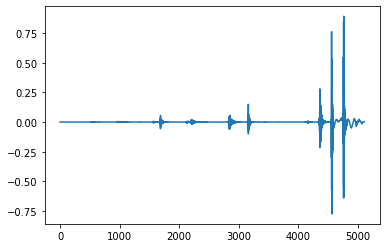

In [95]:
plt.plot(audio)


In [99]:
print(audio.shape)

(5109,)


In [100]:
import scipy.io.wavfile
scipy.io.wavfile.write("thing.wav", 16000, audio[:])

In [ ]:

sf.write('fun.wav', audio, 48000)

In [ ]:
import VocalTractLab.text_to_speech as tts

tts(["I like cats"])-tts(["Cats are very cool and very fun balls"])

In [ ]:
tract_param_info=vtl.VocalTractLabApi.get_param_info('tract').to_numpy()
tract_param_info

In [ ]:
audio=vtl.text_to_speech('This is a test.')
print(audio)

In [ ]:
sf.write('anton.wav', audio, 16000)